# Quantanium (local StateVector simulator)

## Quickstart

In this tutorial, we will walk you through the fundamental procedures for simulating a quantum circuit. Throughout the tutorial, we will provide links to detailed documentation and examples that can provide a deeper understanding of each topic.

### Load the Quantanium Framework

In order to use the simulator, we simply need to import the `quantanium` Python module within youre workspace like this:

In [ ]:
from quantanium import *

### Using Quantanium

Quantanium is a lightning fast state vector engine written in C++. The simulator is available locally, and it is accessible from the user library via

In [ ]:
sim = Quantanium()

The simulator can simulate quantum circuits built with the `sim.execute(circuit)` function or, alternatively, OpenQASM files with the `sim.execute("filename.qasm")` function.

## Example: Simulate a GHZ state preparation circuit

### Construct basic circuit

A circuit is a sequence of quantum operations (gates, measurements, etc...) that act on a set of qubits and potentially store information in a classical or *z* register. The classical register is a boolean vector to store the results of classical measurements, and the *z* register is a complex vector to store the result of mathematical calculations like expectation values.

Quantanium's interface is similar to other software, but there are some important differences:

* There are no hardcoded quantum registers. Qubits are simply indicated by an integer index starting at 0 (Python convention). The same for classical and *z* registers.
* A `Circuit` object doesn't have a fixed number of qubits. The number of qubits in a circuit is taken from looking at the qubits the gates are applied to. It is the maximum integer used in a circuit. The same for the number of classical bits or the `z` register.

To construct a GHZ circuit, we start by defining an empty `Circuit()`

In [3]:
circuit = Circuit()
circuit

empty circuit

The most important tool to build circuits is the `push()` function. It is used like this: `circuit.push(opeeration, targets...)`. It accepts a circuit, a single quantum operation, and a series of targets, one for every qubit or bit the operation supports. 

We apply a `GateH` on the first qubits as 

In [4]:
circuit.push(GateH(), 0)

1-qubit circuit with 1 instructions:
└── H @ q[0]

The text representation `H @ q[0]` informs us that there is an instruction which applies the Hadamard gate to the qubit with index `0`. Note that qubits start by default in the state 0.

Multiple gates can be added at once through the same `push()` syntax using iterables. To prepare a 5-qubits GHZ state, we add 5 `CX` gates or control-$X$ gates between the qubit 0 and all the qubits from `1` to `4`.

In [5]:
circuit.push(GateCX(), 0, range(1, 5))

5-qubit circuit with 5 instructions:
├── H @ q[0]
├── CX @ q[0], q[1]
├── CX @ q[0], q[2]
├── CX @ q[0], q[3]
└── CX @ q[0], q[4]

### Measure, add noise, and extract information


We can extract information about the state of the system (without affecting the state) at any point in the circuit.
For example, we can compute the expectation value of $\ket{11}\bra{11}$ of qubits 0 and 3, and store it in the first *z* register as:

In [6]:
circuit.push(ExpectationValue(Projector11()), 0, 4, 0)

5-qubit circuit with 6 instructions:
├── H @ q[0]
├── CX @ q[0], q[1]
├── CX @ q[0], q[2]
├── CX @ q[0], q[3]
├── CX @ q[0], q[4]
└── ⟨P₁₁(1)⟩ @ q[0,4], z[0]

We can measure the qubits and add other non-unitary operations at any point in the circuit, for example:

In [7]:
circuit.push(Measure(), range(0, 5), range(0, 5))

5-qubit circuit with 11 instructions:
├── H @ q[0]
├── CX @ q[0], q[1]
├── CX @ q[0], q[2]
├── CX @ q[0], q[3]
├── CX @ q[0], q[4]
├── ⟨P₁₁(1)⟩ @ q[0,4], z[0]
├── M @ q[0], c[0]
├── M @ q[1], c[1]
├── M @ q[2], c[2]
├── M @ q[3], c[3]
└── M @ q[4], c[4]

Here, we measure qubits 0 to 4 and store the result in classical register 0 to 4. In general, the ordering of targets is always like `circuit.push(op, quantum_targets..., classical_targets..., z_targets...)`.

**WARNING**: Classical and z registers can be overwritten. If you do `circuit.push(Measure(), 0, 0)` followed by `circuit.push(Measure(), 1, 0)`, the second measurement will overwrite the first one since it will be stored on the same classical register 0. To avoid this in a circuit with many measurements you can, for example, keep track of the index of the last used register.

To simulate imperfect quantum computers, we can add noise to the circuit. Noise operations can be added just like any other operations using `push()`. However, noise can also be added after the circuit has been built to all gates of a certain type using `add_noise()`. For example:

In [8]:
circuit.add_noise(GateH(), AmplitudeDamping(0.01))

5-qubit circuit with 12 instructions:
├── H @ q[0]
├── AmplitudeDamping(0.01) @ q[0]
├── CX @ q[0], q[1]
├── CX @ q[0], q[2]
├── CX @ q[0], q[3]
├── CX @ q[0], q[4]
├── ⟨P₁₁(1)⟩ @ q[0,4], z[0]
├── M @ q[0], c[0]
├── M @ q[1], c[1]
├── M @ q[2], c[2]
├── M @ q[3], c[3]
└── M @ q[4], c[4]

In [9]:
circuit.add_noise(GateCX(), Depolarizing2(0.1), parallel=True)

5-qubit circuit with 16 instructions:
├── H @ q[0]
├── AmplitudeDamping(0.01) @ q[0]
├── CX @ q[0], q[1]
├── Depolarizing(0.1) @ q[0,1]
├── CX @ q[0], q[2]
├── Depolarizing(0.1) @ q[0,2]
├── CX @ q[0], q[3]
├── Depolarizing(0.1) @ q[0,3]
├── CX @ q[0], q[4]
├── Depolarizing(0.1) @ q[0,4]
├── ⟨P₁₁(1)⟩ @ q[0,4], z[0]
├── M @ q[0], c[0]
├── M @ q[1], c[1]
├── M @ q[2], c[2]
├── M @ q[3], c[3]
└── M @ q[4], c[4]

In [10]:
circuit.add_noise(Measure(), PauliX(0.05), before=True, parallel=True)

5-qubit circuit with 21 instructions:
├── H @ q[0]
├── AmplitudeDamping(0.01) @ q[0]
├── CX @ q[0], q[1]
├── Depolarizing(0.1) @ q[0,1]
├── CX @ q[0], q[2]
├── Depolarizing(0.1) @ q[0,2]
├── CX @ q[0], q[3]
├── Depolarizing(0.1) @ q[0,3]
├── CX @ q[0], q[4]
├── Depolarizing(0.1) @ q[0,4]
├── ⟨P₁₁(1)⟩ @ q[0,4], z[0]
├── PauliX(0.05) @ q[0]
├── PauliX(0.05) @ q[0]
├── PauliX(0.05) @ q[0]
├── PauliX(0.05) @ q[0]
├── PauliX(0.05) @ q[0]
├── M @ q[0], c[0]
├── M @ q[1], c[1]
├── M @ q[2], c[2]
⋮   ⋮
└── M @ q[4], c[4]

The number of qubits, classical bits, and complex z-values of a circuit can be obtained from:

In [11]:
circuit.num_qubits(), circuit.num_bits(), circuit.num_zvars()

(5, 5, 1)

A circuit behaves in many ways like a vector (of instructions, i.e. operations + targets). You can get the length as `len(circuit)`, access elements as `circuit[2]`, insert elements with `insert()`, append other circuits with `append()` etc. You can also visualize circuits with `draw()`.

In [12]:
circuit.draw()

        ┌─┐┌──────────────────────┐   ┌───────────────────┐                     
 q[0]: ╶┤H├┤AmplitudeDamping(0.01)├─●─┤0                  ├───●────────────────╴
        └─┘└──────────────────────┘┌┴┐│  Depolarizing(0.1)│   │                 
 q[1]: ╶───────────────────────────┤X├┤1                  ├───┼────────────────╴
                                   └─┘└───────────────────┘  ┌┴┐                
 q[2]: ╶─────────────────────────────────────────────────────┤X├───────────────╴
                                                             └─┘                
 q[3]: ╶───────────────────────────────────────────────────────────────────────╴
                                                                                
 q[4]: ╶───────────────────────────────────────────────────────────────────────╴
                                                                                
                                                                                
                            

### Execute Circuit

Executing a circuit with quantanium:

In [13]:
res = sim.execute(circuit)
res

QCSResults:
├── simulator: QLEO 0.1.22
├── timings:
│    └── apply time: 0.616514992s
├── fidelity estimate:
│    ├── min, max: 1, 1
│    ├── mean: 1
│    ├── median: 1
│    └── std: 0
├── average multi-qubit gate error estimate:
│    ├── min, max: 0, 0
│    ├── mean: 0
│    ├── median: 0
│    └── std: 0
├── most sampled:
│    ├── bs"00000" => 305
│    ├── bs"11111" => 290
│    ├── bs"10000" => 82
│    ├── bs"01111" => 74
│    └── bs"01000" => 31
├── zreg (most sampled):
│    ├── [0j] => 61
│    ├── [(0.4974874371859298+0j)] => 777
│    └── [(0.5025125628140706+0j)] => 162
├── 1000 executions
├── 0 amplitudes
└── 1000 samples

This will execute a simulation of the given circuit with default parameters. Check out the documentation of [`execute()`](https://docs.qperfect.io/mimiqcircuits-python/apidocs/mimiqcircuits.html#mimiqcircuits.MimiqConnection.execute) function for details.

The return value of the `execute` function is a `QCSResults` type.

To make a histogram out of the retrieved samples, it suffices to execute

In [14]:
res.histogram()

{frozenbitarray('00101'): 1,
 frozenbitarray('00000'): 305,
 frozenbitarray('00001'): 16,
 frozenbitarray('11111'): 290,
 frozenbitarray('01000'): 31,
 frozenbitarray('10000'): 82,
 frozenbitarray('00100'): 14,
 frozenbitarray('00010'): 14,
 frozenbitarray('01110'): 26,
 frozenbitarray('10111'): 29,
 frozenbitarray('01111'): 74,
 frozenbitarray('00111'): 3,
 frozenbitarray('10001'): 20,
 frozenbitarray('10011'): 17,
 frozenbitarray('11101'): 9,
 frozenbitarray('11110'): 11,
 frozenbitarray('01100'): 17,
 frozenbitarray('11011'): 10,
 frozenbitarray('01101'): 3,
 frozenbitarray('10110'): 4,
 frozenbitarray('10101'): 2,
 frozenbitarray('00011'): 6,
 frozenbitarray('11000'): 7,
 frozenbitarray('01011'): 1,
 frozenbitarray('01010'): 3,
 frozenbitarray('11010'): 1,
 frozenbitarray('10010'): 1,
 frozenbitarray('01001'): 2,
 frozenbitarray('11100'): 1}

### Visualization

To plot the results use the following:

In [ ]:
from quantanium.visualization import plothistogram

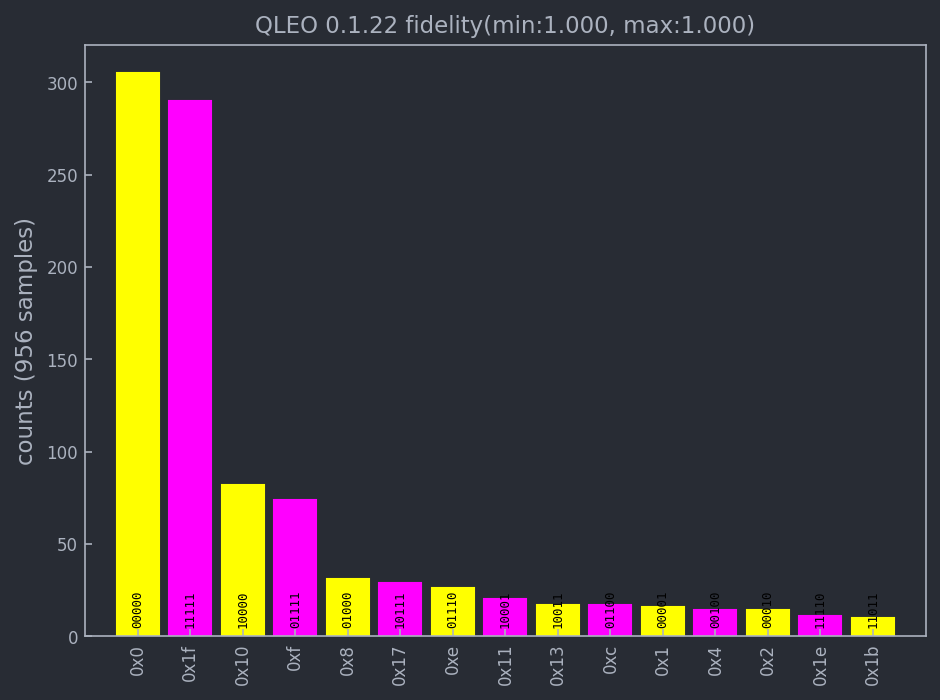

In [18]:
plothistogram(res);

### OpenQASM

OpenQASM files, defining quantum algorithms, can be exececuted with Quantanium in the same way native circuit can, simply use `execute()` and provide the path of the file to upload.

In [19]:
circ_wstate = sim.parse_qasm("wstate_n3.qasm")
res_wstate = sim.execute(circ_wstate)
res_wstate

QCSResults:
├── simulator: QLEO 0.1.22
├── timings:
│    ├── sample time: 0.00010581s
│    └── apply time: 0.000108185s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"010" => 336
│    ├── bs"001" => 334
│    └── bs"100" => 330
├── 1 executions
├── 0 amplitudes
└── 1000 samples

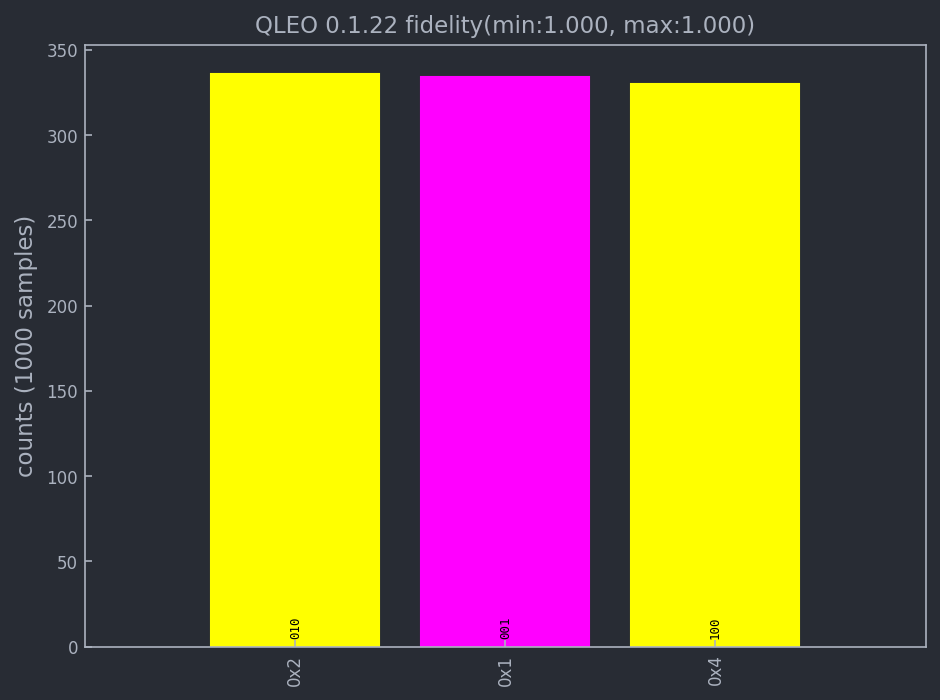

In [20]:
plothistogram(res_wstate);

In [21]:
res_factor = sim.execute("factor247_n15.qasm")
res_factor

QCSResults:
├── simulator: QLEO 0.1.22
├── timings:
│    ├── sample time: 0.002663487s
│    └── apply time: 8.717896449s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"1101011" => 91
│    ├── bs"1010111" => 76
│    ├── bs"1010110" => 74
│    ├── bs"1101001" => 73
│    └── bs"1010100" => 71
├── 1 executions
├── 0 amplitudes
└── 1000 samples

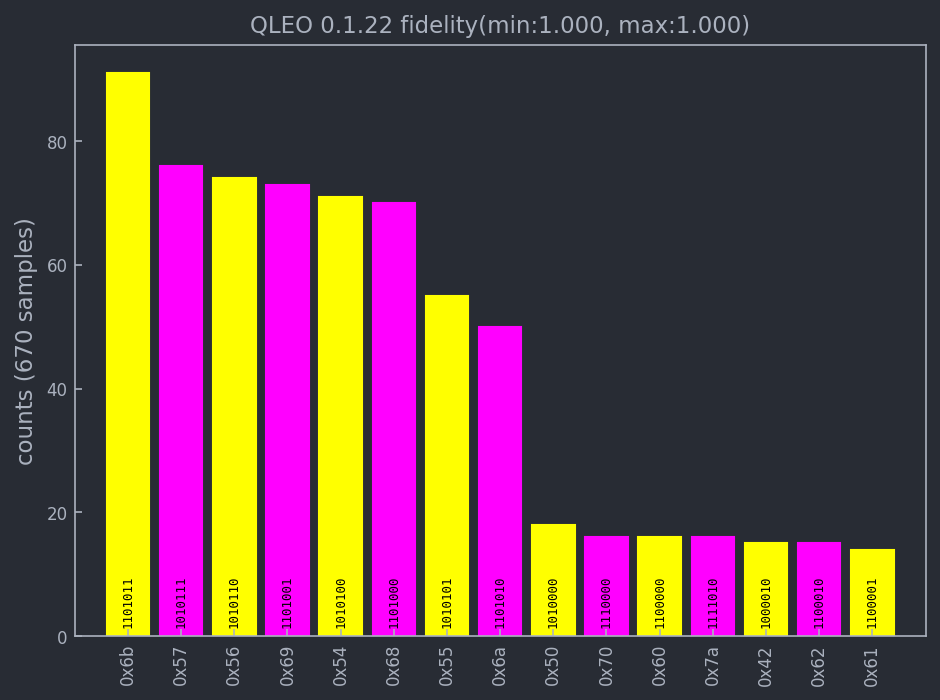

In [22]:
plothistogram(res_factor);